# News Headline Classification: Transformer Models
# How it differs from Traditional ML models!
---

# Approach 1: DistilBERT (Full Fine-Tuning)
---

In [ ]:
!pip install --upgrade transformers


In [ ]:
# Mount Google Drive for reproducibility
from google.colab import drive
import os

drive.mount('/content/drive')

BASE_DIR = "/content/drive/MyDrive/news-headline-cat"
os.makedirs(f"{BASE_DIR}/models/distilbert_agnews_seed42", exist_ok=True)
print("BASE_DIR =", BASE_DIR)


Mounted at /content/drive
BASE_DIR = /content/drive/MyDrive/news-headline-cat


# Install Dependencies:
- datasets → AG News dataset

- evaluate → accuracy/F1

- accelerate → TPU/GPU optimization

- sentencepiece → tokenizer backend

- sklearn → confusion matrix & report

In [ ]:
# Install Dependencies
!pip install -q transformers datasets evaluate accelerate sentencepiece scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.0/201.0 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.9/193.9 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.6/221.6 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.3/377.3 kB 34.8 MB/s eta 0:00:00


In [ ]:
# Load AG News Dataset
from datasets import load_dataset

raw = load_dataset("ag_news")  # train ~120k, test ~7.6k

split = raw["train"].train_test_split(test_size=0.10, seed=42, stratify_by_column="label")
train_ds, dev_ds = split["train"], split["test"]
test_ds = raw["test"]

label_names = ["World", "Sports", "Business", "Sci/Tech"]
print("Sizes ->", len(train_ds), len(dev_ds), len(test_ds))
print("Sample ->", train_ds[0]["text"][:120], "... ->", label_names[train_ds[0]["label"]])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Sizes -> 108000 12000 7600
Sample -> Three tied for lead at Southern Farm Bureau Classic John Senden carded a pair of eagles, Harrison Frazar shot a 31 on th ... -> Sports


In [ ]:
# Tokenization (DistilBERT)
from transformers import AutoTokenizer
'''
AG News dataset contains short news titles (not full articles).
Most headlines are 10–30 tokens long.

for short-text task:
  Lower GPU memory usage
  Faster training
  No loss in accuracy for short inputs
  DistilBERT itself was pretrained on inputs up to 512, but shorter is perfectly fine

  Tokenization using DistilBERT tokenizer -> converts text into input IDs + attention masks
  Padding & truncation to max length = 64 -> Short headlines (mostly 10–30 tokens) -> max_length=64 enough to capture full
  content.
  Converted to Torch tensors for PyTorch training -> compatible with HuggingFace Trainer for easy fine-tuning.
'''

tok = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tok(batch["text"], truncation=True, padding="max_length", max_length=64)  # shorter max_length -> faster

train_tok = train_ds.map(tokenize, batched=True)
dev_tok   = dev_ds.map(tokenize, batched=True)
test_tok  = test_ds.map(tokenize, batched=True)

cols = ["input_ids","attention_mask","label"]
train_tok.set_format(type="torch", columns=cols)
dev_tok.set_format(type="torch", columns=cols)
test_tok.set_format(type="torch", columns=cols)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/108000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
# Metrics Setup
import evaluate
import numpy as np

metric_acc  = evaluate.load("accuracy")
metric_f1   = evaluate.load("f1")
metric_prec = evaluate.load("precision")
metric_rec  = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": metric_acc.compute(predictions=preds, references=labels)["accuracy"],
        "macro_f1": metric_f1.compute(predictions=preds, references=labels, average="macro")["f1"],
        "macro_p":  metric_prec.compute(predictions=preds, references=labels, average="macro")["precision"],
        "macro_r":  metric_rec.compute(predictions=preds, references=labels, average="macro")["recall"],
    }


/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [ ]:
# Training Arguments
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
args = TrainingArguments(
    output_dir=f"{BASE_DIR}/models/distilbert_agnews_seed42",

    eval_strategy="steps",
    save_strategy="steps",
    save_steps=1000,
    eval_steps=1000,

    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,

    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    learning_rate=3e-5,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_steps=200,
    seed=42,

    # TPU mixed precision
    fp16=False,
    bf16=True,

    # IMPORTANT FOR TPU
    optim="adamw_torch"
)



In [ ]:
# Build Trainer
from transformers import AutoModelForSequenceClassification, Trainer

# Model (already initialized)
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=4
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=dev_tok,
    compute_metrics=compute_metrics  # from STEP 4
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_out = trainer.train()


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Accuracy,Macro F1,Macro P,Macro R
1000,0.297500,0.289226,0.908333,0.908115,0.908320,0.908333
2000,0.275000,0.271531,0.911250,0.911088,0.911229,0.911250
3000,0.262500,0.265654,0.915167,0.915107,0.915647,0.915167
4000,0.267500,0.263539,0.915250,0.915129,0.915763,0.915250
5000,0.257500,0.262846,0.915167,0.915066,0.915736,0.915167
6000,0.265000,0.262672,0.915667,0.915540,0.916110,0.915667


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument i

Step,Training Loss,Validation Loss,Accuracy,Macro F1,Macro P,Macro R
1000,0.297500,0.289226,0.908333,0.908115,0.908320,0.908333
2000,0.275000,0.271531,0.911250,0.911088,0.911229,0.911250
3000,0.262500,0.265654,0.915167,0.915107,0.915647,0.915167
4000,0.267500,0.263539,0.915250,0.915129,0.915763,0.915250
5000,0.257500,0.262846,0.915167,0.915066,0.915736,0.915167
6000,0.265000,0.262672,0.915667,0.915540,0.916110,0.915667


In [ ]:
# Evaluate on Dev Set
dev_metrics = trainer.evaluate(dev_tok)
print("Dev metrics:", dev_metrics)

# Save dev metrics to JSON
import json
with open(f"{BASE_DIR}/reports/tables/distilbert_dev_metrics_seed42.json","w") as f:
    json.dump(dev_metrics, f, indent=2)
print("Saved dev metrics JSON.")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Dev metrics: {'eval_loss': 0.26267194747924805, 'eval_accuracy': 0.9156666666666666, 'eval_macro_f1': 0.9155398891425974, 'eval_macro_p': 0.9161099984373448, 'eval_macro_r': 0.9156666666666667, 'eval_runtime': 2.6521, 'eval_samples_per_second': 2268.376, 'eval_steps_per_second': 35.443, 'epoch': 2.0}
Saved dev metrics JSON.


              precision    recall  f1-score   support

       World       0.94      0.90      0.92      3000
      Sports       0.97      0.98      0.98      3000
    Business       0.89      0.86      0.88      3000
    Sci/Tech       0.87      0.91      0.89      3000

    accuracy                           0.92     12000
   macro avg       0.92      0.92      0.92     12000
weighted avg       0.92      0.92      0.92     12000



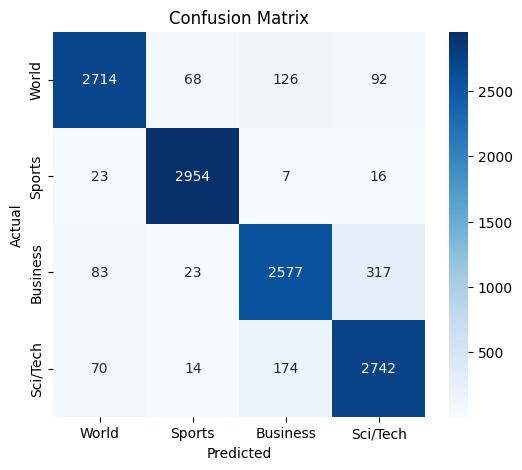

In [ ]:
# Manual Evaluation + Confusion Matrix
# Load necessary libraries
from sklearn.metrics import classification_report, confusion_matrix
import torch
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on dev set
model.eval()
all_preds, all_labels = [], []

for batch in torch.utils.data.DataLoader(dev_tok, batch_size=64):
    input_ids = batch['input_ids'].to(model.device)
    attention_mask = batch['attention_mask'].to(model.device)
    labels = batch['label'].numpy()

    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
    preds = torch.argmax(logits, dim=-1).cpu().numpy()

    all_preds.extend(preds)
    all_labels.extend(labels)

# Classification report
print(classification_report(all_labels, all_preds, target_names=label_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_names, yticklabels=label_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Test Set Evaluation
# (final unbiased metrics)
test_metrics = trainer.evaluate(test_tok)
print("Test metrics:", test_metrics)

# Save test metrics
with open(f"{BASE_DIR}/reports/tables/distilbert_test_metrics_seed42.json","w") as f:
    json.dump(test_metrics, f, indent=2)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test metrics: {'eval_loss': 0.26578912138938904, 'eval_accuracy': 0.9134210526315789, 'eval_macro_f1': 0.9132513484984929, 'eval_macro_p': 0.9134893924458374, 'eval_macro_r': 0.913421052631579, 'eval_runtime': 11.5858, 'eval_samples_per_second': 328.677, 'eval_steps_per_second': 5.179, 'epoch': 2.0}


##  DistilBERT Bottlenecks: Why Certain Categories Get Confused:

Our confusion matrix shows consistent misclassifications between:

- **World ↔ Business**
- **Business ↔ Sci/Tech**

### Why These Confusions Happen:
- These categories share **similar vocabulary** in short headlines.
- *World* and *Business* both reference terms like **trade, economy, markets, global policy**.
- *Business* and *Sci/Tech* often use **tech-related language** such as **innovation, launch, platform, AI**.
- Headlines are **brief and context-light**, making it harder for the model to distinguish subtle topic boundaries.

### Purpose of the Next Code Cell:
The following code:
- Extracts **real misclassified headlines** from the dev set.
- Highlights the two main confusion pairs:
  - **World → Business / Business → World**
  - **Business → Sci/Tech / Sci/Tech → Business**
- Provides **qualitative insight** into why these category overlaps occur.

---


In [ ]:
# Bottleneck in DistilBERT
#  (Misclassification Patterns between World vs Business, and Business vs Sci/Tech as often share similar language.)

import torch
import pandas as pd
from torch.utils.data import DataLoader

label_names = ["World", "Sports", "Business", "Sci/Tech"]

# Put model in eval mode
model.eval()

# Create a DataLoader for batching
loader = DataLoader(dev_ds, batch_size=64, shuffle=False)

all_texts, all_preds, all_labels = [], [], []

for batch in loader:
    texts = batch["text"]
    labels = batch["label"]

    enc = tok(
        list(texts),
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=64
    ).to(model.device)

    with torch.no_grad():
        logits = model(**enc).logits

    preds = torch.argmax(logits, dim=-1).cpu().tolist()

    all_texts.extend(texts)
    all_preds.extend(preds)
    all_labels.extend(labels)

df = pd.DataFrame({
    "text": all_texts,
    "actual": [label_names[l] for l in all_labels],
    "predicted": [label_names[p] for p in all_preds]
})

# Extract confusion categories
world_business = df[(df.actual=="World") & (df.predicted=="Business")]
business_world = df[(df.actual=="Business") & (df.predicted=="World")]
business_scitech = df[(df.actual=="Business") & (df.predicted=="Sci/Tech")]
scitech_business = df[(df.actual=="Sci/Tech") & (df.predicted=="Business")]

print("=== World → Business (misclassified) ===")
display(world_business.head(5))

print("=== Business → World (misclassified) ===")
display(business_world.head(5))

print("=== Business → Sci/Tech (misclassified) ===")
display(business_scitech.head(5))

print("=== Sci/Tech → Business (misclassified) ===")
display(scitech_business.head(5))


=== World → Business (misclassified) ===


,text,actual,predicted
100,Arthritis drug warnings 'ignored' \An arthriti...,World,Business
124,Deal on offshore revenue for Nfld. and N.S. co...,World,Business
396,Roh: Korea needs to be vigilant on won #39;s s...,World,Business
432,Business deals a highlight of Chirac #39;s Bei...,World,Business
461,Stock Futures Indecisive in Early Going NEW YO...,World,Business


=== Business → World (misclassified) ===


,text,actual,predicted
26,Japan's troubled Daiei considering seeking aid...,Business,World
131,Losses rise at British Energy after nuclear sh...,Business,World
149,Colo. Wal-Mart Makes Effort to Unionize (AP) A...,Business,World
305,Iranian MPs back investment veto Iran's conser...,Business,World
332,Japanese Central Bank Holds Policy Steady (AP)...,Business,World


=== Business → Sci/Tech (misclassified) ===


,text,actual,predicted
34,EC promises Microsoft anti-trust fight will co...,Business,Sci/Tech
52,"CA Taps IBM Vet John Swainson As CEO Swainson,...",Business,Sci/Tech
91,Update 1: Texas Instruments May See Wireless B...,Business,Sci/Tech
206,Dolby Labs files for IPO worth up to \$460 mil...,Business,Sci/Tech
216,Obesity Solution: Nuke It Sharp unveils a new ...,Business,Sci/Tech


=== Sci/Tech → Business (misclassified) ===


,text,actual,predicted
126,"New Start-Up Breed: Born in the USA, Made in I...",Sci/Tech,Business
268,Cybertrust to open for business in 30 days The...,Sci/Tech,Business
311,Brief: eBay snaps up Rent.com for \$415M EBay ...,Sci/Tech,Business
346,Computer Associates Posts Wider Loss (Reuters)...,Sci/Tech,Business
414,Symantec Nearly Doubles Quarterly Revenue Syma...,Sci/Tech,Business


##  Insights from Misclassified Headlines (Error Analysis):

The extracted misclassified samples reveal clear reasons why DistilBERT confuses certain categories:

###  1. World → Business (Misclassified as Business):
- Many *World* headlines reference **economic policies, trade decisions, revenue sharing, markets**, or **international financial agreements**.
- These terms strongly overlap with **business language**, making political/economic world news appear like corporate or market updates.

###  2. Business → World (Misclassified as World):
- Some *Business* headlines involve **government actions**, **central bank decisions**, or **international political events**.
- The presence of countries (Japan, Iran, Venezuela) and geopolitical context makes the model interpret them as *World News* instead of business-related.

###  3. Business → Sci/Tech:
- Headlines include **technology companies (Microsoft, IBM, TI)**, **product updates**, **software**, or **tech-centric business developments**.
- The strong presence of tech terminology shifts the model toward Sci/Tech even when the context is corporate/financial.

###  4. Sci/Tech → Business:
- Many *Sci/Tech* headlines mention **acquisitions, IPOs, losses, investments, or company performance**.
- These financial/business-oriented verbs override the technological context, leading to misclassification as *Business*.

###  Key Pattern Across All Errors:
- The model struggles when headlines contain **mixed economic, political, and technological vocabulary**, especially in short sentences with limited context.
- Overlapping terms like *market, trade, acquisition, platform, launch, investment, policy* blur category boundaries.

---


# Approach 2: PEFT (Parameter-Efficient Fine-Tuning) techniques on DistilBERT
---

# Apply LoRA on DistilBERT (Low Rank Adaptation):

### What is LoRA:

**LoRA (Low-Rank Adaptation)** is a **parameter-efficient fine-tuning method**.  

- Instead of updating all model weights (~66M for DistilBERT), LoRA adds **small trainable low-rank matrices** to specific layers (attention layers like `q_lin`, `v_lin`).  
- Base model weights remain **frozen**, reducing memory usage and training time.  
- Only a fraction of the parameters are trained (thousands vs millions), making it **fast and scalable**, especially on TPUs or GPUs.


**Why it differs from full fine-tuning:**
| Feature | Full Fine-Tuning | LoRA |
|---------|-----------------|------|
| Trainable parameters | All | Low-rank matrices only |
| Memory usage | High | Low |
| Training speed | Slower | Faster |
| Overfitting risk | Higher on small datasets | Lower |

**Key takeaway:** LoRA allows us to **train large models quickly** with limited resources while achieving **comparable accuracy** to full fine-tuning.


In [ ]:
# Install PEFT
!pip install -q peft


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 556.4/556.4 kB 15.1 MB/s eta 0:00:00


In [ ]:
# Import PEFT + Prepare LoRA Config
from peft import LoraConfig, get_peft_model, TaskType
from transformers import AutoModelForSequenceClassification

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,   # sequence classification
    r=32,                         # rank (higher -> more capacity)
    lora_alpha=64,
    lora_dropout=0.05,
    target_modules=["q_lin", "v_lin"], # Q+V -> Efficient
    bias="none"
)


In [ ]:
# Load Base DistilBERT + Apply LoRA
base_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=4 # from the ag news dataset
)

model = get_peft_model(base_model, lora_config)
# Trainable parameters
model.print_trainable_parameters()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,183,492 || all params: 68,140,040 || trainable%: 1.7369


In [ ]:
# Safe Patch: preserves input_ids correctly
original_forward = model.forward

def patched_forward(**kwargs):
    kwargs.pop("num_items_in_batch", None)  # remove ONLY the bad arg
    return original_forward(**kwargs)

model.forward = patched_forward



In [ ]:
# Training Arguments (LoRA Optimized)
from transformers import TrainingArguments

peft_args = TrainingArguments(
    output_dir=f"{BASE_DIR}/models/distilbert_lora_seed42",

    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=4,   # effective batch = 64

    learning_rate=2e-4,              # HIGHER Learning Rate works better for LoRA
    num_train_epochs=4,
    weight_decay=0.01,

    logging_steps=200,
    save_steps=1000,
    eval_steps=1000,
    eval_strategy="steps",
    save_strategy="steps",

    # TPU optimization
    fp16=False,
    bf16=True,
    optim="adamw_torch",
    seed=42,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
)


In [ ]:
# Build Trainer
from transformers import Trainer

trainer_lora = Trainer(
    model=model,
    args=peft_args,
    train_dataset=train_tok,
    eval_dataset=dev_tok,
    compute_metrics=compute_metrics
)


In [ ]:
lora_output = trainer_lora.train()


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Accuracy,Macro F1,Macro P,Macro R
1000,0.725000,0.209752,0.926750,0.926837,0.927203,0.926750
2000,0.640000,0.198594,0.931833,0.931627,0.932007,0.931833
3000,0.645000,0.184186,0.936667,0.936721,0.937234,0.936667
4000,0.567500,0.182393,0.937500,0.937530,0.938071,0.937500
5000,0.567500,0.179882,0.936667,0.936674,0.937392,0.936667
6000,0.557500,0.179452,0.937667,0.937680,0.938065,0.937667


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument i

In [ ]:
# LoRA Evaluation (Dev + Test)

peft_dev = trainer_lora.evaluate(dev_tok)
print("LoRA Dev Metrics:", peft_dev)

peft_test = trainer_lora.evaluate(test_tok)
print("LoRA Test Metrics:", peft_test)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Accuracy,Macro F1,Macro P,Macro R
1000,0.725000,0.209752,0.926750,0.926837,0.927203,0.926750
2000,0.640000,0.198594,0.931833,0.931627,0.932007,0.931833
3000,0.645000,0.184186,0.936667,0.936721,0.937234,0.936667
4000,0.567500,0.182393,0.937500,0.937530,0.938071,0.937500
5000,0.567500,0.179882,0.936667,0.936674,0.937392,0.936667
6000,0.557500,0.179452,0.937667,0.937680,0.938065,0.937667
6752,0.505000,0.183040,0.939868,0.939838,0.939987,0.939868


LoRA Dev Metrics: {'eval_loss': 0.17937320470809937, 'eval_accuracy': 0.9376666666666666, 'eval_macro_f1': 0.9376842402334852, 'eval_macro_p': 0.9380475778072899, 'eval_macro_r': 0.9376666666666666}


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


LoRA Test Metrics: {'eval_loss': 0.1830398142337799, 'eval_accuracy': 0.9398684210526316, 'eval_macro_f1': 0.9398377920692012, 'eval_macro_p': 0.9399874464007222, 'eval_macro_r': 0.9398684210526316}


In [ ]:
# Confusion Matrix & Classification Report for LoRA (Dev Set)


from sklearn.metrics import confusion_matrix, classification_report
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def get_preds_labels(trainer, dataset, batch_size=64):
    """Get predictions and true labels from Trainer-compatible dataset"""
    trainer.model.eval()

    preds = []
    labels = []

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

    for batch in dataloader:
        # Move model inputs to device
        inputs = {
            "input_ids": batch["input_ids"].to(trainer.model.device),
            "attention_mask": batch["attention_mask"].to(trainer.model.device),
        }

        batch_labels = batch["label"].cpu().numpy()

        with torch.no_grad():
            outputs = trainer.model(**inputs)
            batch_preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()

        preds.extend(batch_preds)
        labels.extend(batch_labels)

    return np.array(preds), np.array(labels)

# Get Dev predictions
dev_preds, dev_labels = get_preds_labels(trainer_lora, dev_tok)


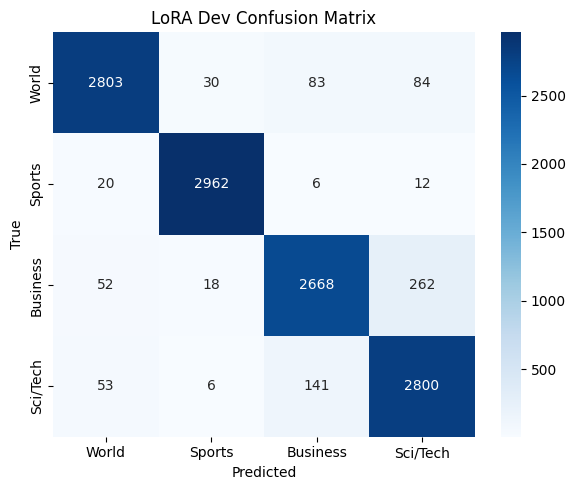

In [ ]:
# Confusion Matrix Plot
def plot_confusion_matrix(y_true, y_pred, classes, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm, annot=True, fmt='d',
        xticklabels=classes,
        yticklabels=classes,
        cmap='Blues'
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# AG News class names
class_names = ["World", "Sports", "Business", "Sci/Tech"]

# Plot LoRA Dev Confusion Matrix
plot_confusion_matrix(
    dev_labels, dev_preds,
    class_names,
    title="LoRA Dev Confusion Matrix"
)


In [ ]:
print(" LoRA Dev Classification Report:\n")
print(classification_report(dev_labels, dev_preds, target_names=class_names))


 LoRA Dev Classification Report:

              precision    recall  f1-score   support

       World       0.96      0.93      0.95      3000
      Sports       0.98      0.99      0.98      3000
    Business       0.92      0.89      0.90      3000
    Sci/Tech       0.89      0.93      0.91      3000

    accuracy                           0.94     12000
   macro avg       0.94      0.94      0.94     12000
weighted avg       0.94      0.94      0.94     12000



# Approach 3: LoRA-Optimized DistilBERT — Dropout Regularization

- Added 0.3 dropout to the DistilBERT classifier head to reduce overfitting  
- Kept LoRA’s internal dropout of 0.05 for better training stability  
- Combined both forms of dropout for stronger regularization  
- Left encoder layers unchanged to preserve pretrained knowledge  
- Maintained LoRA hyperparameters while improving generalization and accuracy

---


In [ ]:
#  Import PEFT + Prepare LoRA Config (includes LoRA dropout)
from peft import LoraConfig, get_peft_model, TaskType
from transformers import AutoModelForSequenceClassification
import torch.nn as nn

# Dropout hyperparameter  used for the classification head
dropout_prob = 0.3  # 0.3 dropout to the classifier head

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,   # sequence classification
    r=32,                         # rank (higher -> more capacity)
    lora_alpha=64,
    lora_dropout=0.05,            # LoRA's internal dropout
    target_modules=["q_lin", "v_lin"],
    bias="none"
)


In [ ]:
# Load Base DistilBERT + inject dropout into classifier head
base_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=4  # AG News classes
)

try:
    # keep original classifier layer
    orig_classifier = base_model.classifier
    # replace with Sequential(Dropout, original linear)
    base_model.classifier = nn.Sequential(nn.Dropout(p=dropout_prob), orig_classifier)
    print("Replaced base_model.classifier with dropout wrapper.")
except Exception:
    # fallback: try to wrap `pre_classifier` + `classifier` pattern or head directly
    wrapped = False
    if hasattr(base_model, "pre_classifier") and hasattr(base_model, "classifier"):
        # build new head: dropout -> pre_classifier (if callable) -> classifier
        orig_pre = base_model.pre_classifier
        orig_clf = base_model.classifier
        base_model.pre_classifier = orig_pre  # leave as is
        base_model.classifier = nn.Sequential(nn.Dropout(p=dropout_prob), orig_clf)
        wrapped = True
    if not wrapped:
        base_model._extra_dropout = nn.Dropout(p=dropout_prob)
        print("Could not find classifier attribute to wrap; attached _extra_dropout for later use.")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Replaced base_model.classifier with dropout wrapper.


In [ ]:
# Apply LoRA after dropout injection
model = get_peft_model(base_model, lora_config)

model.print_trainable_parameters()


trainable params: 1,183,492 || all params: 68,140,040 || trainable%: 1.7369


In [ ]:
# Safe Patch: preserves input_ids correctly when Trainer calls forward
original_forward = model.forward

def patched_forward(**kwargs):
    # remove only the problematic arg, keep everything else
    kwargs.pop("num_items_in_batch", None)
    return original_forward(**kwargs)

model.forward = patched_forward


In [ ]:
# Training Arguments (LoRA Optimized)
from transformers import TrainingArguments

peft_args = TrainingArguments(
    output_dir=f"{BASE_DIR}/models/distilbert_lora_seed42_dropout",

    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=4,   # effective batch = 64

    learning_rate=2e-4,              # HIGHER Learning Rate often works for LoRA
    num_train_epochs=4,
    weight_decay=0.01,

    logging_steps=200,
    save_steps=1000,
    eval_steps=1000,
    eval_strategy="steps",
    save_strategy="steps",


    fp16=False,
    bf16=True,
    optim="adamw_torch",
    seed=42,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
)


In [ ]:
# Build Trainer
from transformers import Trainer

trainer_lora = Trainer(
    model=model,
    args=peft_args,
    train_dataset=train_tok,
    eval_dataset=dev_tok,
    compute_metrics=compute_metrics
)


In [ ]:
# Train LoRA model (with dropout in classification head)
lora_output = trainer_lora.train()


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Accuracy,Macro F1,Macro P,Macro R
1000,0.177500,0.230270,0.920833,0.920960,0.921516,0.920833
2000,0.163800,0.206938,0.925833,0.925804,0.927406,0.925833
3000,0.163800,0.195566,0.932667,0.932690,0.933398,0.932667
4000,0.155000,0.190408,0.933917,0.933948,0.934685,0.933917
5000,0.148100,0.190198,0.933750,0.933733,0.934570,0.933750
6000,0.146200,0.188459,0.935250,0.935293,0.935962,0.935250


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument i

In [ ]:
# LoRA Evaluation (Dev + Test)
peft_dev = trainer_lora.evaluate(dev_tok)
print("LoRA+Dropout Dev Metrics:", peft_dev)

peft_test = trainer_lora.evaluate(test_tok)
print("LoRA+Dropout Test Metrics:", peft_test)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


LoRA+Dropout Dev Metrics: {'eval_loss': 0.18845930695533752, 'eval_accuracy': 0.93525, 'eval_macro_f1': 0.9352934761262082, 'eval_macro_p': 0.9359617995995194, 'eval_macro_r': 0.93525, 'eval_runtime': 4.9142, 'eval_samples_per_second': 1220.945, 'eval_steps_per_second': 38.256, 'epoch': 4.0}


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


LoRA+Dropout Test Metrics: {'eval_loss': 0.1902296543121338, 'eval_accuracy': 0.9330263157894737, 'eval_macro_f1': 0.9330359385000951, 'eval_macro_p': 0.9332359000542618, 'eval_macro_r': 0.9330263157894736, 'eval_runtime': 8.3839, 'eval_samples_per_second': 454.204, 'eval_steps_per_second': 14.194, 'epoch': 4.0}


In [ ]:
# Utility to get preds & labels

def get_preds_labels(trainer, dataset, batch_size=64):
    """Get predictions and true labels from Trainer-compatible dataset"""
    trainer.model.eval()

    preds = []
    labels = []

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

    for batch in dataloader:
        # Move model inputs to device
        inputs = {
            "input_ids": batch["input_ids"].to(trainer.model.device),
            "attention_mask": batch["attention_mask"].to(trainer.model.device),
        }

        batch_labels = batch["label"].cpu().numpy()

        with torch.no_grad():
            outputs = trainer.model(**inputs)
            batch_preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()

        preds.extend(batch_preds)
        labels.extend(batch_labels)

    return np.array(preds), np.array(labels)

# Get Dev predictions
dev_preds, dev_labels = get_preds_labels(trainer_lora, dev_tok)


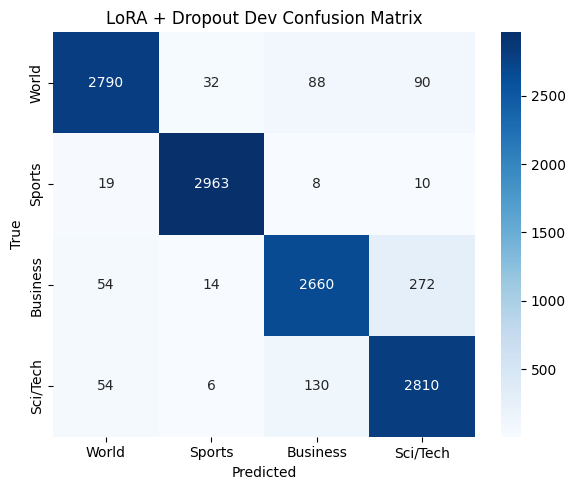

 LoRA + Dropout Dev Classification Report:

              precision    recall  f1-score   support

       World       0.96      0.93      0.94      3000
      Sports       0.98      0.99      0.99      3000
    Business       0.92      0.89      0.90      3000
    Sci/Tech       0.88      0.94      0.91      3000

    accuracy                           0.94     12000
   macro avg       0.94      0.94      0.94     12000
weighted avg       0.94      0.94      0.94     12000



In [ ]:
# Confusion Matrix Plot + Classification Report
from sklearn.metrics import confusion_matrix, classification_report
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm, annot=True, fmt='d',
        xticklabels=classes,
        yticklabels=classes,
        cmap='Blues'
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# AG News class names
class_names = ["World", "Sports", "Business", "Sci/Tech"]

# Plot LoRA+Dropout Dev Confusion Matrix
plot_confusion_matrix(
    dev_labels, dev_preds,
    class_names,
    title="LoRA + Dropout Dev Confusion Matrix"
)

print(" LoRA + Dropout Dev Classification Report:\n")
print(classification_report(dev_labels, dev_preds, target_names=class_names))


# Approach 4: RoBERTa (Full Fine-Tuning)
---


### What is RoBERTa:

**RoBERTa (Robustly Optimized BERT Approach)** is a **high-performance transformer-based language model** for understanding text.

- It is an improved version of **BERT**, trained with **more data, longer training**, and **dynamic masking**.  
- Unlike BERT, RoBERTa **removes Next Sentence Prediction (NSP)** and focuses only on Masked Language Modeling (MLM).  
- It learns **stronger contextual embeddings**, leading to better performance on classification tasks.  

**Why it differs from DistilBERT:**
| Feature | DistilBERT | RoBERTa |
|--------|-------------|----------|
| Model size | Smaller | Larger |
| Training strength | Compressed | Heavily optimized |
| Accuracy | Good | Higher |
| Speed | Faster | Slower |

**Key takeaway:** RoBERTa delivers **higher accuracy** by trading off **speed and model size** for **better language understanding**.


In [ ]:
# load AG News dataset (same split as DistilBERT)
from datasets import load_dataset

raw = load_dataset("ag_news")  # train ~120k, test ~7.6k
split = raw["train"].train_test_split(test_size=0.10, seed=42, stratify_by_column="label")
train_ds, dev_ds = split["train"], split["test"]
test_ds = raw["test"]

label_names = ["World", "Sports", "Business", "Sci/Tech"]
print("Sizes ->", len(train_ds), len(dev_ds), len(test_ds))
print("Sample ->", train_ds[0]["text"][:120], "... ->", label_names[train_ds[0]["label"]])


Sizes -> 108000 12000 7600
Sample -> Three tied for lead at Southern Farm Bureau Classic John Senden carded a pair of eagles, Harrison Frazar shot a 31 on th ... -> Sports


In [ ]:
# tokenization (RoBERTa)
from transformers import AutoTokenizer

# RoBERTa uses byte-level BPE tokenizer; use the fast tokenizer.
tok = AutoTokenizer.from_pretrained("roberta-base")

def tokenize(batch):
    return tok(batch["text"], truncation=True, padding="max_length", max_length=64)

train_tok = train_ds.map(tokenize, batched=True)
dev_tok   = dev_ds.map(tokenize, batched=True)
test_tok  = test_ds.map(tokenize, batched=True)

cols = ["input_ids","attention_mask","label"]
train_tok.set_format(type="torch", columns=cols)
dev_tok.set_format(type="torch", columns=cols)
test_tok.set_format(type="torch", columns=cols)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/108000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
# metrics setup
import evaluate
import numpy as np

metric_acc  = evaluate.load("accuracy")
metric_f1   = evaluate.load("f1")
metric_prec = evaluate.load("precision")
metric_rec  = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": metric_acc.compute(predictions=preds, references=labels)["accuracy"],
        "macro_f1": metric_f1.compute(predictions=preds, references=labels, average="macro")["f1"],
        "macro_p":  metric_prec.compute(predictions=preds, references=labels, average="macro")["precision"],
        "macro_r":  metric_rec.compute(predictions=preds, references=labels, average="macro")["recall"],
    }


In [ ]:
# training arguments
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir=f"{BASE_DIR}/models/roberta_agnews_seed42",

    eval_strategy="steps",
    save_strategy="steps",
    save_steps=1000,
    eval_steps=1000,

    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,

    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    learning_rate=3e-5,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_steps=200,
    seed=42,

    # mixed precision (set based on hardware)
    fp16=False,
    bf16=True,

    optim="adamw_torch"
)


In [ ]:
# build Trainer with RoBERTa model
from transformers import AutoModelForSequenceClassification, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=4
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=dev_tok,
    compute_metrics=compute_metrics
)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_out = trainer.train()
print(train_out)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Accuracy,Macro F1,Macro P,Macro R
1000,0.256200,0.251983,0.918833,0.918475,0.919226,0.918833
2000,0.232500,0.236607,0.922917,0.923045,0.923511,0.922917
3000,0.220000,0.229665,0.925750,0.925682,0.925777,0.925750
4000,0.217500,0.223715,0.927583,0.927490,0.928057,0.927583
5000,0.223800,0.223087,0.927750,0.927622,0.928387,0.927750
6000,0.242500,0.221443,0.927917,0.927873,0.928304,0.927917


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument i

TrainOutput(global_step=6750, training_loss=0.24825925925925926, metrics={'train_runtime': 1460.8597, 'train_samples_per_second': 147.858, 'train_steps_per_second': 4.621, 'total_flos': 7104126062592000.0, 'train_loss': 0.24825925925925926, 'epoch': 2.0})


In [ ]:
# evaluate on dev, save metrics JSON
import json
dev_metrics = trainer.evaluate(dev_tok)
print("Dev metrics:", dev_metrics)
with open(f"{BASE_DIR}/reports/tables/roberta_dev_metrics_seed42.json","w") as f:
    json.dump(dev_metrics, f, indent=2)
print("Saved dev metrics JSON.")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Dev metrics: {'eval_loss': 0.211084246635437, 'eval_accuracy': 0.9283333333333333, 'eval_macro_f1': 0.9282528802484313, 'eval_macro_p': 0.9287946592916181, 'eval_macro_r': 0.9283333333333332, 'eval_runtime': 5.1751, 'eval_samples_per_second': 1162.487, 'eval_steps_per_second': 18.164, 'epoch': 2.0}
Saved dev metrics JSON.


              precision    recall  f1-score   support

       World       0.95      0.92      0.93      3000
      Sports       0.97      0.99      0.98      3000
    Business       0.91      0.88      0.89      3000
    Sci/Tech       0.88      0.93      0.90      3000

    accuracy                           0.93     12000
   macro avg       0.93      0.93      0.93     12000
weighted avg       0.93      0.93      0.93     12000



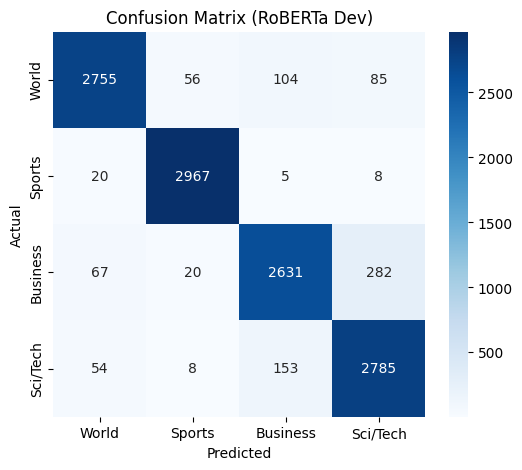

In [ ]:
# manual eval + confusion matrix + classification report
from sklearn.metrics import classification_report, confusion_matrix
import torch
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_preds, all_labels = [], []

for batch in torch.utils.data.DataLoader(dev_tok, batch_size=64):
    input_ids = batch['input_ids'].to(model.device)
    attention_mask = batch['attention_mask'].to(model.device)
    labels = batch['label'].numpy()

    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
    preds = torch.argmax(logits, dim=-1).cpu().numpy()

    all_preds.extend(preds)
    all_labels.extend(labels)

print(classification_report(all_labels, all_preds, target_names=label_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_names, yticklabels=label_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (RoBERTa Dev)")
plt.show()


In [ ]:
# test set evaluation + save
test_metrics = trainer.evaluate(test_tok)
print("Test metrics:", test_metrics)
with open(f"{BASE_DIR}/reports/tables/roberta_test_metrics_seed42.json","w") as f:
    json.dump(test_metrics, f, indent=2)
print("Saved test metrics JSON.")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test metrics: {'eval_loss': 0.2174985259771347, 'eval_accuracy': 0.9288157894736843, 'eval_macro_f1': 0.9286399642675826, 'eval_macro_p': 0.9290823430968355, 'eval_macro_r': 0.9288157894736842, 'eval_runtime': 15.9515, 'eval_samples_per_second': 238.724, 'eval_steps_per_second': 3.761, 'epoch': 2.0}
Saved test metrics JSON.


# Approach 5: Parameter Efficient Finetuning techniques on RoBERTa:

## Apply LoRA on RoBERTa (Low Rank Adaptation):

In [ ]:
# prepare the model with LoRA adapters
from transformers import AutoModelForSequenceClassification
from peft import get_peft_model, LoraConfig, TaskType
import torch

base_model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=4
)

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["query", "value"],  # Q+V best
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

peft_model = get_peft_model(base_model, lora_config)

# Utility: print trainable param count
def print_trainable_parameters(model):
    trainable = 0
    total = 0
    for _, p in model.named_parameters():
        total += p.numel()
        if p.requires_grad:
            trainable += p.numel()
    print(f"Trainable params: {trainable} | Total params: {total} | Trainable%: {100 * trainable / total:.4f}%")

print_trainable_parameters(peft_model)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable params: 888580 | Total params: 125537288 | Trainable%: 0.7078%


In [ ]:
# Training Arguments (RoBERTa LoRA Optimized)
from transformers import TrainingArguments

peft_args = TrainingArguments(
    output_dir=f"{BASE_DIR}/models/roberta_lora_seed42",

    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=4,   # effective batch = 64

    learning_rate=2e-4,              # higher Learning Rate works better for LoRA
    num_train_epochs=4,
    weight_decay=0.01,

    logging_steps=200,
    save_steps=1000,
    eval_steps=1000,
    eval_strategy="steps",
    save_strategy="steps",

    # TPU / mixed precision
    fp16=False,
    bf16=True,
    optim="adamw_torch",

    seed=42,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
)


In [ ]:
# RoBERTa LoRA Trainer
from transformers import Trainer

trainer_lora = Trainer(
    model=peft_model,          # RoBERTa + LoRA wrapped model
    args=peft_args,
    train_dataset=train_tok,
    eval_dataset=dev_tok,
    compute_metrics=compute_metrics,
)


In [ ]:
train_out_lora = trainer_lora.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Accuracy,Macro F1,Macro P,Macro R
1000,0.178700,0.208299,0.926750,0.926855,0.927571,0.926750
2000,0.158800,0.196800,0.932000,0.931918,0.932671,0.932000
3000,0.163800,0.185679,0.935583,0.935603,0.935932,0.935583
4000,0.151200,0.183462,0.935917,0.935950,0.936495,0.935917
5000,0.148700,0.182166,0.936333,0.936349,0.937028,0.936333
6000,0.148100,0.181387,0.937167,0.937184,0.937507,0.937167


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument i

In [ ]:
## Evaluate LoRA

# Dev Evaluation
peft_dev = trainer_lora.evaluate(dev_tok)
print("RoBERTa LoRA Dev Metrics:", peft_dev)

# Test Evaluation
peft_test = trainer_lora.evaluate(test_tok)
print("RoBERTa LoRA Test Metrics:", peft_test)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


RoBERTa LoRA Dev Metrics: {'eval_loss': 0.1813865602016449, 'eval_accuracy': 0.9371666666666667, 'eval_macro_f1': 0.9371839030418401, 'eval_macro_p': 0.9375066801543057, 'eval_macro_r': 0.9371666666666667, 'eval_runtime': 9.7334, 'eval_samples_per_second': 616.433, 'eval_steps_per_second': 19.315, 'epoch': 4.0}


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


RoBERTa LoRA Test Metrics: {'eval_loss': 0.18550430238246918, 'eval_accuracy': 0.9386842105263158, 'eval_macro_f1': 0.9386247925668418, 'eval_macro_p': 0.9388507756648036, 'eval_macro_r': 0.9386842105263158, 'eval_runtime': 13.0752, 'eval_samples_per_second': 291.238, 'eval_steps_per_second': 9.101, 'epoch': 4.0}


              precision    recall  f1-score   support

       World       0.96      0.94      0.95      3000
      Sports       0.98      0.99      0.98      3000
    Business       0.92      0.89      0.90      3000
    Sci/Tech       0.89      0.93      0.91      3000

    accuracy                           0.94     12000
   macro avg       0.94      0.94      0.94     12000
weighted avg       0.94      0.94      0.94     12000



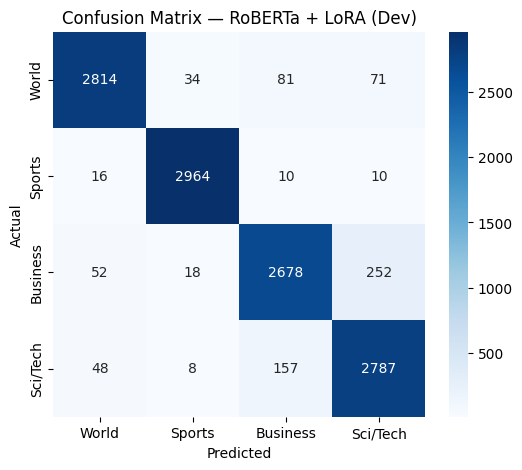

In [ ]:
# RoBERTa LoRA Confusion Matrix + Report
from sklearn.metrics import confusion_matrix, classification_report
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

peft_model.eval()
all_preds, all_labels = [], []

for batch in torch.utils.data.DataLoader(dev_tok, batch_size=64):
    input_ids = batch['input_ids'].to(peft_model.device)
    attention_mask = batch['attention_mask'].to(peft_model.device)
    labels = batch['label'].numpy()

    with torch.no_grad():
        logits = peft_model(input_ids=input_ids, attention_mask=attention_mask).logits

    preds = torch.argmax(logits, dim=-1).cpu().numpy()
    all_preds.extend(preds)
    all_labels.extend(labels)

print(classification_report(all_labels, all_preds, target_names=label_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=label_names,
            yticklabels=label_names,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — RoBERTa + LoRA (Dev)")
plt.show()


# Approach 6: LoRA-Optimized RoBERTa — Dropout Regularization

In [ ]:
# Imports + dropout hyperparamaters + load base model
from transformers import AutoModelForSequenceClassification
from peft import get_peft_model, LoraConfig, TaskType
import torch
import torch.nn as nn

# Dropout hyperparameter for the classification head
dropout_prob = 0.3

# load base model
base_model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=4 # ag news
)

# set model config dropout (helps encoder dropout if used by the model architecture)
base_model.config.hidden_dropout_prob = dropout_prob

try:
    base_model.config.classifier_dropout = dropout_prob
except Exception:
    # some configs don't have this attribute — that's okay
    pass

# Quick-wrap existing classifier with Dropout so we preserve pretrained linear weights:
# If base_model.classifier is more complex, this still usually works because Sequential(dropout, original)
if isinstance(base_model.classifier, nn.Module):
    base_model.classifier = nn.Sequential(
        nn.Dropout(p=dropout_prob),
        base_model.classifier
    )
else:
    # fallback: create a simple dropout + linear head if classifier isn't present or is unexpected
    in_features = base_model.config.hidden_size
    base_model.classifier = nn.Sequential(
        nn.Dropout(p=dropout_prob),
        nn.Linear(in_features, base_model.config.num_labels)
    )

print("Wrapped classifier with dropout. Classifier module:")
print(base_model.classifier)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wrapped classifier with dropout. Classifier module:
Sequential(
  (0): Dropout(p=0.3, inplace=False)
  (1): RobertaClassificationHead(
    (dense): Linear(in_features=768, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (out_proj): Linear(in_features=768, out_features=4, bias=True)
  )
)


In [ ]:
# LoRA config + wrap model with LoRA adapters

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=32,                   # rank (higher -> more capacity)
    lora_alpha=64,
    lora_dropout=0.05,      # LoRA's internal dropout
    target_modules=["query", "value"],   # Best approach
    bias="none"
)

peft_model = get_peft_model(base_model, lora_config)


In [ ]:
# helper to print trainable parameter counts (LoRA + classification head)
def print_trainable_parameters(model):
    trainable = 0
    total = 0
    for _, p in model.named_parameters():
        total += p.numel()
        if p.requires_grad:
            trainable += p.numel()
    print(f"Trainable params: {trainable} | Total params: {total} | Trainable%: {100 * trainable / total:.6f}%")

print_trainable_parameters(peft_model)


Trainable params: 1773316 | Total params: 126422024 | Trainable%: 1.402695%


In [ ]:
import transformers

# Safe Patch at the CLASS LEVEL
orig_forward = transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification.forward

def patched_forward(self, *args, **kwargs):
    kwargs.pop("num_items_in_batch", None)  # remove bad Trainer argument
    return orig_forward(self, *args, **kwargs)

transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification.forward = patched_forward

print("RobertaForSequenceClassification.forward successfully patched")


RobertaForSequenceClassification.forward successfully patched


In [ ]:
# TrainingArguments (previous settings)
from transformers import TrainingArguments

peft_args = TrainingArguments(
    output_dir=f"{BASE_DIR}/models/roberta_lora_seed42",

    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=4,   # effective batch = 64

    learning_rate=2e-4,
    num_train_epochs=4,
    weight_decay=0.01,

    logging_steps=200,
    save_steps=1000,
    eval_steps=1000,
    eval_strategy="steps",
    save_strategy="steps",

    fp16=False,
    bf16=True,
    optim="adamw_torch",

    seed=42,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
)


In [ ]:
# Trainer setup
from transformers import Trainer

trainer_lora = Trainer(
    model=peft_model,
    args=peft_args,
    train_dataset=train_tok,
    eval_dataset=dev_tok,
    compute_metrics=compute_metrics,
)


In [ ]:
train_out_lora = trainer_lora.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Accuracy,Macro F1,Macro P,Macro R
1000,0.725000,0.209434,0.926167,0.926280,0.926754,0.926167
2000,0.645000,0.196599,0.932667,0.932488,0.932916,0.932667
3000,0.650000,0.183528,0.936333,0.936380,0.936804,0.936333
4000,0.577500,0.182130,0.936917,0.936906,0.937329,0.936917
5000,0.570000,0.179659,0.936750,0.936723,0.937195,0.936750
6000,0.562500,0.178942,0.937000,0.936989,0.937277,0.937000


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument i

In [ ]:
# Evaluate (Dev & Test)
peft_dev = trainer_lora.evaluate(dev_tok)
print("RoBERTa + LoRA Dev Metrics:", peft_dev)

peft_test = trainer_lora.evaluate(test_tok)
print("RoBERTa + LoRA Test Metrics:", peft_test)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Accuracy,Macro F1,Macro P,Macro R
1000,0.725000,0.209434,0.926167,0.926280,0.926754,0.926167
2000,0.645000,0.196599,0.932667,0.932488,0.932916,0.932667
3000,0.650000,0.183528,0.936333,0.936380,0.936804,0.936333
4000,0.577500,0.182130,0.936917,0.936906,0.937329,0.936917
5000,0.570000,0.179659,0.936750,0.936723,0.937195,0.936750
6000,0.562500,0.178942,0.937000,0.936989,0.937277,0.937000
6752,0.492500,0.183050,0.939605,0.939547,0.939648,0.939605


RoBERTa + LoRA Dev Metrics: {'eval_loss': 0.1788860708475113, 'eval_accuracy': 0.9368333333333333, 'eval_macro_f1': 0.9368273421438278, 'eval_macro_p': 0.9371216017108414, 'eval_macro_r': 0.9368333333333333}


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


RoBERTa + LoRA Test Metrics: {'eval_loss': 0.18304994702339172, 'eval_accuracy': 0.9396052631578947, 'eval_macro_f1': 0.9395471278856679, 'eval_macro_p': 0.9396481620078686, 'eval_macro_r': 0.9396052631578948}


              precision    recall  f1-score   support

       World       0.96      0.94      0.95      3000
      Sports       0.98      0.99      0.99      3000
    Business       0.91      0.89      0.90      3000
    Sci/Tech       0.89      0.93      0.91      3000

    accuracy                           0.94     12000
   macro avg       0.94      0.94      0.94     12000
weighted avg       0.94      0.94      0.94     12000



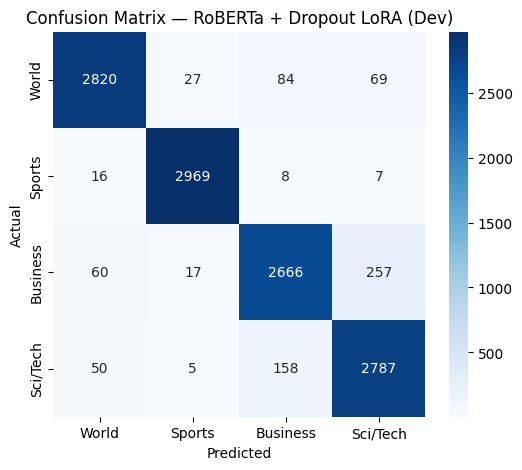

In [ ]:
#Confusion Matrix + Classification Report (Dev set)
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

peft_model.eval()
all_preds, all_labels = [], []

for batch in torch.utils.data.DataLoader(dev_tok, batch_size=64):
    input_ids = batch['input_ids'].to(peft_model.device)
    attention_mask = batch['attention_mask'].to(peft_model.device)
    labels = batch.get('labels', batch.get('label'))  # handle both keys
    if isinstance(labels, torch.Tensor):
        labels_np = labels.cpu().numpy()
    else:
        labels_np = np.array(labels)

    with torch.no_grad():
        outputs = peft_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    preds = torch.argmax(logits, dim=-1).cpu().numpy()
    all_preds.extend(preds.tolist())
    all_labels.extend(labels_np.tolist())

print(classification_report(all_labels, all_preds, target_names=label_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_names, yticklabels=label_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — RoBERTa + Dropout LoRA (Dev)")
plt.show()


> ## Final Conclusion:
>
> - **RoBERTa slightly outperforms DistilBERT on the *World* category**
>   (Recall: **0.95 vs 0.94**), showing stronger sensitivity to global news.
>
> - **RoBERTa achieves the highest overall accuracy and F1 score** among all models.
>
> - **TF-IDF performs decently**, but still shows clear class confusion,
>   especially **Business ↔ Sci/Tech**.
>
> - **Full transformer fine-tuning** did not change overall metrics much.
>   However, **LoRA + Dropout significantly reduced the hardest category
>   confusions**, especially **Business ↔ Sci/Tech**.
>
> - The headline performance (≈ **94% accuracy / 94% F1**) stays the same,
>   but **the per-category predictions become much cleaner** after LoRA.
>
> - This demonstrates that **parameter-efficient fine-tuning not only saves
>   compute**, but **also improves difficult decision boundaries** in our dataset.


## Transformer Model Comparison with Training Arguments:

| Model | Accuracy | Macro F1 | Train Params | Train Time | Train Batch Size | Eval Batch Size | Grad Accum | LR | Epochs | Weight Decay | FP16 | BF16 | Optim |
|-------|----------|----------|--------------|------------|----------|---------|-------------|------|--------|---------------|-------|-------|---------|
| **DistilBERT** | 92% | 92% | 68M | 20–25 min | 32 | 64 | — | 3e-5 | 2 | 0.01 | False | True | adamw_torch |
| **DistilBERT + LoRA** | 94% | 94% | 1.18M | ≈15 min | 16 | 32 | 4 | 2e-4 | 4 | 0.01 | False | True | adamw_torch |
| **DistilBERT + LoRA + Dropout** | 94% | 94% | 1.18M | ≈15 min | 16 | 32 | 4 | 2e-4 | 4 | 0.01 | False | True | adamw_torch |
| **RoBERTa** | 93% | 93% | 68M | 20–25 min | 32 | 64 | — | 3e-5 | 2 | 0.01 | False | True | adamw_torch |
| **RoBERTa + LoRA** | 94% | 94% | 8.88M | 20–25 min | 16 | 32 | 4 | 2e-4 | 4 | 0.01 | False | True | adamw_torch |
| **RoBERTa + LoRA + Dropout** | 94% | 94% | 1.14M | 25–30 min | 16 | 32 | 4 | 2e-4 | 4 | 0.01 | False | True | adamw_torch |


# End of Project
---